# Getting the Data Ready for Model Use
This notebook is for cleaning up data, generate more columns, change data type, etc.


In [2]:
import os
from pathlib import Path # added to make the file locations dynamic and usable with Windows #Need to test on MAC
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# created this to find the main Airbnb folder (Windows & Mac compatible)
def GoToParentFolder(folder_name):
    path = Path(os.getcwd())
    path_string = str(path)

    while path_string[-len(folder_name):] != folder_name:
        path = Path(path.parent)
        path_string = str(path)
        print(path_string)
        
    return(str(path))

In [6]:
# Change working directory to the data folder
airbnb_main_directory = GoToParentFolder('Airbnb-Price-Prediction')

data_folder = os.path.join(airbnb_main_directory,'data','new-york-city-airbnb-open-data')
print(data_folder)

C:\Users\darie\Desktop\Python Practice\Airbnb-Price-Prediction
C:\Users\darie\Desktop\Python Practice\Airbnb-Price-Prediction\data\new-york-city-airbnb-open-data


In [7]:
#read data, specify index so it's easier to join and search using loc
listings_csv = os.path.join(data_folder,'selected_rows_listings.csv')
listings = pd.read_csv(listings_csv)

In [8]:
#to get all columns, set option
pd.set_option('display.max_columns', 107)
#to get text with no truncation
pd.set_option('display.max_colwidth', -1)

In [9]:
#shape
listings.shape

(27926, 42)

In [10]:
listings.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_verifications', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'reviews_per_month', 'cleaning_fee_yes_no', 'security_deposit_yes_no',
       'extra_people_yes_no', 'last_review_days_ago'],
      dtype='object')

In [11]:
# Dropping unused original columns as 'derived' columns were created or it maybe redundant
Unused_columns = ['host_verifications', 'security_deposit', 'cleaning_fee','extra_people', 'first_review', 'last_review']

listings.drop(columns=Unused_columns, inplace = True)

# Dealing with null values
Fill with 0, dropping null, fill with avg

In [12]:
#dorp null records
Drop_na = ['host_since', 'host_listings_count', 'host_identity_verified', 'host_is_superhost']
listings = listings.dropna(subset=Drop_na)


In [13]:
#fill null with 0
Fill_with_zero = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_response_time','host_acceptance_rate']

for column in Fill_with_zero:
    listings[column] = listings[column].replace(np.nan, '0')


# New features

In [14]:
#amenities_count

listings['amenities_count'] = listings['amenities'].str.count(',')
print (listings['amenities_count'].sort_values(ascending=False).head())

# drop original column
listings.drop(columns='amenities', inplace = True)

22351    63
22340    62
1103     61
7370     60
22348    60
Name: amenities_count, dtype: int64


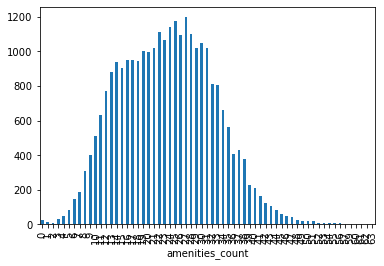

In [15]:
#chart it
df = listings.groupby('amenities_count')['amenities_count'].size()
df.plot(kind='bar')

In [16]:
# host_response_time

def convert_string_to_int(row):
    if row == 'within an hour':
        row = '1'
    else: row = '0'
    return row

listings['host_response_time_one_hour'] = listings['host_response_time'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='host_response_time', inplace = True)

#check result
print(listings.groupby('host_response_time_one_hour')['host_response_time_one_hour'].size())


host_response_time_one_hour
0.0    11968
1.0    15958
Name: host_response_time_one_hour, dtype: int64


In [17]:
# host_response_rate

def convert_string_to_int(row):
    if row == '100%':
        row = '1'
    else: row = '0'
    return row

listings['host_response_rate_calc'] = listings['host_response_rate'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='host_response_rate', inplace = True)

#check result
print(listings.groupby('host_response_rate_calc')['host_response_rate_calc'].size())

host_response_rate_calc
0.0    10166
1.0    17760
Name: host_response_rate_calc, dtype: int64


In [18]:
#host_acceptance_rate
#needs to use function that conver 100% to 1 and the rest to 0 (from previous cell)

listings['host_acceptance_rate_calc'] = listings['host_acceptance_rate'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='host_acceptance_rate', inplace = True)

#check result
print(listings.groupby('host_acceptance_rate_calc')['host_acceptance_rate_calc'].size())

host_acceptance_rate_calc
0.0    18962
1.0    8964 
Name: host_acceptance_rate_calc, dtype: int64


In [19]:
#property_type, after modeling, loft seems to affect price. But looking at the data loft price is between 28 and 900 dollars.
# I am going to split propety type into two, apt or non
#listings.groupby('property_type').agg({'property_type': 'size', 'price':'max'}).sort_values(by='price',ascending=False)

def convert_string_to_int(row):
    if row == 'Apartment':
        row = '1'
    else: row = '0'
    return row

listings['apt_yes_no'] = listings['property_type'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='property_type', inplace = True)

#check result
print(listings.groupby('apt_yes_no')['apt_yes_no'].size())


apt_yes_no
0.0    6722 
1.0    21204
Name: apt_yes_no, dtype: int64


In [20]:
#bed_type --- may not be needed, let's see

def convert_string_to_int(row):
    if row == 'Real Bed':
        row = '1'
    else: row = '0'
    return row

listings['real_bed_yes_no'] = listings['bed_type'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='bed_type', inplace = True)

#check result
print(listings.groupby('real_bed_yes_no')['real_bed_yes_no'].size())

real_bed_yes_no
0.0    345  
1.0    27581
Name: real_bed_yes_no, dtype: int64


In [21]:
#cancellation_policy -- let's do 3 classes (flexible, moderate, and strict)

def convert_string_to_int(row):
    row = row.replace('strict_14_with_grace_period', 'strict')
    row = row.replace('super_strict_30', 'strict')
    row = row.replace('super_strict_60', 'strict')
    return row

#new column
listings['cancellation_policy_calc'] = listings['cancellation_policy'].apply(lambda col: convert_string_to_int(col))

# drop original column
listings.drop(columns='cancellation_policy', inplace = True)

#check result
print(listings.groupby('cancellation_policy_calc')['cancellation_policy_calc'].size())



cancellation_policy_calc
flexible    5377 
moderate    7167 
strict      15382
Name: cancellation_policy_calc, dtype: int64


In [22]:
#host_listings_count

def convert_string_to_int(row):
    if row < 1:
        row = 0
    else: row = 1
    return row

listings['multiple_listings'] = listings['host_listings_count'].apply(lambda col: convert_string_to_int(col)).astype(float)

# drop original column
listings.drop(columns='host_listings_count', inplace = True)

#check result
print(listings.groupby('multiple_listings')['multiple_listings'].size())


multiple_listings
0.0    2936 
1.0    24990
Name: multiple_listings, dtype: int64


# Category conversion
Use one hot encoding

In [23]:
# Get one hot encoding of column neighbourhood_group_cleansed
one_hot_encoding_columns = ['neighbourhood_group_cleansed', 'room_type', 'cancellation_policy_calc']
listings = pd.get_dummies(data=listings, columns=one_hot_encoding_columns)

# Boolean conversion
Converting the value to 1 and 0 from 't' and 'f'.

In [24]:
#function to replace
def convert_bool(row):
    row = row.replace('f', '0')
    row = row.replace('t', '1')
    return row

In [25]:
# #update rows and convert to boo
Boolean_columns = ['host_is_superhost', 'is_location_exact', 'instant_bookable', 'host_identity_verified']

for column in Boolean_columns:
    listings[column] = listings[column].apply(lambda col: convert_bool(col)).astype(int)


# Date conversion
Convert to date then to ordinal

In [26]:
#conver to date first
listings['host_since'] = pd.to_datetime(listings['host_since'])

listings['host_since'] = listings['host_since'].apply(lambda x: x.toordinal())



In [27]:
listings['host_since'].head()

0    733294
1    733383
2    733440
3    733441
4    733469
Name: host_since, dtype: int64

In [28]:
listings.head(1).T

,0
id,2595
host_since,733294
host_is_superhost,0
host_identity_verified,1
is_location_exact,0
accommodates,2
bathrooms,1
bedrooms,0
beds,1
price,225


In [29]:
listings.columns.values

array(['id', 'host_since', 'host_is_superhost', 'host_identity_verified',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'guests_included', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'instant_bookable', 'reviews_per_month', 'cleaning_fee_yes_no',
       'security_deposit_yes_no', 'extra_people_yes_no',
       'last_review_days_ago', 'amenities_count',
       'host_response_time_one_hour', 'host_response_rate_calc',
       'host_acceptance_rate_calc', 'apt_yes_no', 'real_bed_yes_no',
       'multiple_listings', 'neighbourhood_group_cleansed_Bronx',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleanse

# Export to CSV
Clean data for model to use

In [30]:
print(listings.shape)

(27926, 45)


In [31]:
#export columns left to csv to be used with second notebook
path = data_folder

listings_csv = os.path.join(path,'model_columns_listings.csv')
listings.to_csv(listings_csv)